# XGBoostによる分類モデルのテスト
最適なパラメータを探す
## データ準備

In [64]:
import re
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import nltk
import torch
from pprint import pprint
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics._scorer import _SCORERS
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from transformers import AutoModel

In [2]:
df = pd.read_csv("./fake_job_postings.csv")
df = df.drop("job_id", axis=1) # job_id = 0,1,2,... 学習価値なし
# df.fillna('null', inplace=True) # 空の文字列 -> null (XGBoost APIでは無くてもいける？)

# 偽文書と本物文書
Fakedf = df[ df['fraudulent'] == 1 ]
Realdf = df[ df['fraudulent'] == 0 ]

# 問題文データのランダム抽出 (偽文書割合50%)
detaset_Fake, quiz_Fake = train_test_split(Fakedf, test_size=50)
detaset_Real, quiz_Real = train_test_split(Realdf, test_size=50)

# 問題文データのランダムシャッフル
quizdf = pd.concat([quiz_Real, quiz_Fake])
shuffled_df = quizdf.sample(frac=1).reset_index(drop=True)
quiz = shuffled_df.drop("fraudulent", axis=1)        # 問題文
quiz_solution = shuffled_df["fraudulent"].to_numpy() # 解答

# 訓練データとテストデータへの分割 (テストデータ25%)
train_Fake, test_Fake = train_test_split(detaset_Fake)
train_Real, test_Real = train_test_split(detaset_Real)
traindf = pd.concat([train_Real, train_Fake])
testdf = pd.concat([test_Real, test_Fake])
traindf = traindf.sample(frac=1).reset_index(drop=True)
testdf = testdf.sample(frac=1).reset_index(drop=True)
train_X = testdf.drop('fraudulent', axis=1)
train_y = testdf['fraudulent']
test_X = testdf.drop('fraudulent', axis=1)
test_y = testdf['fraudulent']

データの傾向を確認する。

In [3]:
train_X.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,Desktop / Windows 7 Engineer,"US, MN, Minneapolis",NaN,NaN,i28 Technologies has demonstrated expertise in...,Role: Desktop Package/ D...,"WAN/LAN, TCIPIP, DHCP, DNS, VPN, Active Direct...",NaN,0,1,0,NaN,NaN,NaN,NaN,NaN
1,Backstage Pass Internship,"US, ID, Boise",Digital,NaN,Since 1978Our goal has been to create engaging...,THE BACKSTAGE PASS INTERNSHIP IS BACKThe Backs...,Individuals with the following skills will be ...,"Access: We are a busy agency, but we sincerely...",0,1,1,NaN,NaN,NaN,Marketing and Advertising,Advertising
2,Entry Level Sales,"US, OH, Columbus",NaN,55000-75000,NaN,General Summary: Achieves maximum sales profit...,NaN,Great Health and DentalFast Advancement Opport...,1,0,0,Full-time,Entry level,High School or equivalent,Financial Services,Sales
3,Title Account Executive,"US, AL, Birmingham",NaN,NaN,Network Closing Services has been serving Lend...,"This is who we are: Network Closing Services, ...",What you should know:**Experienced candidates ...,What's in it for you?**SIGN ON BONUS AVAILABLE...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Real Estate,NaN
4,Appointment Coordinator,"US, OH, Columbus",NaN,50-65,"LEI Home Enhancements, is an Ohio based compan...",Job DescriptionJob DescriptionOur Appointment ...,NaN,NaN,0,1,0,Full-time,Entry level,NaN,Consumer Services,NaN


カテゴリカルデータの値と頻度を確認

In [4]:
category_columns = ['location','department','salary_range','employment_type','required_experience','required_education','industry','function']
for cc in category_columns:
    print(f"---{cc}---")
    pprint(train_X[cc].value_counts())

---location---
location
GB, LND, London          172
US, NY, New York         158
GR, I, Athens            121
US, CA, San Francisco    107
US, ,                    102
                        ... 
US, ME, Lewiston           1
US, AZ, MESA               1
US, NM, Silver City        1
US, LA, Ruston             1
GB, , Wakefield            1
Name: count, Length: 1381, dtype: int64
---department---
department
Sales                      126
Engineering                118
Marketing                  105
Operations                  65
IT                          55
                          ... 
Medical                      1
Experience                   1
Telephone Interpreters       1
Servicing-Customer Care      1
GVS                          1
Name: count, Length: 527, dtype: int64
---salary_range---
salary_range
0-0                33
30000-40000        17
40000-50000        14
35000-45000        11
55000-75000        10
                   ..
30-50               1
10-Nov              1
6

カテゴリカルデータをすべてOne-hot encodeするのは現実的ではない。

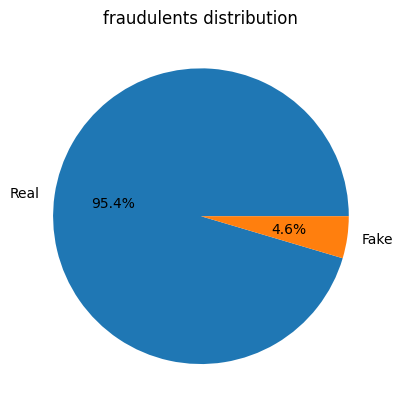

In [5]:
train_y.value_counts().rename(index={0: 'Real', 1: 'Fake'}).plot(kind='pie', autopct='%1.1f%%')
plt.title('fraudulents distribution')
plt.ylabel('')  # y軸ラベルを非表示にする
plt.show()

偽文書と本物文書の割合が不均衡のため、精度だけでモデル性能を評価するのは適切ではない。
不均衡なデータセットでは、多数派クラス（この場合はReal）を予測するだけで高い精度を達成できるため、モデルの真の性能を正確に反映しないことがある。

よって評価にはF1 score（適合率と再現率の調和平均）を用いる。
- 適合率（Precision）
  - 適合率はFakeと予測されたインスタンスのうち、実際にFakeである割合。
  - 積極的にRealと予測するとPrecisionが高くなる
- 再現率（Recall）
  - 再現率は、実際にFakeであるインスタンスのうち、正しくFakeと予測された割合です。
  - 積極的にFakeと予測するとRecallが高くなる
- 両者はトレードオフ関係にあり、バランスが大事

In [6]:
# 利用可能な評価指標
pprint(sorted(_SCORERS.keys()))

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

### 訓練データの加工
前処理を行って、データを扱いやすくする。

#### カテゴリカルデータのエンコード
employment_typeをOne-Hot encodeする

In [7]:
encoded_train_X = pd.get_dummies(train_X, columns=['employment_type'])
encoded_test_X = pd.get_dummies(test_X, columns=['employment_type'])
print(encoded_train_X.columns)

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'required_experience',
       'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary'],
      dtype='object')


required_experienceとrequired_educationをレベル別に数値化する。

In [8]:
def int_convert(value):
    try:
        output = int(value)
        return output
    except ValueError:
        return np.nan
    
# required_experience
def encoder_experience(text):
    experience_levels = {
        "Not Applicable": 0,
        "Internship": 1,
        "Entry level": 2,
        "Associate": 3,
        "Mid-Senior level": 4,
        "Director": 5,
        "Executive": 6
    }
    return int_convert(experience_levels.get(text, np.nan))

# required_education
def encoder_education(text):
    education_levels = {
        "Unspecified": 0,
        "Some High School Coursework": 1,
        "High School or equivalent": 2,
        "Vocational - HS Diploma": 2,
        "Some College Coursework Completed": 3,
        "Associate Degree": 4,
        "Vocational - Degree": 5,
        "Certification": 5,
        "Bachelor's Degree": 5,
        "Professional": 6,
        "Master's Degree": 7,
        "Doctorate": 8
    }
    return int_convert(education_levels.get(text, np.nan))

In [9]:
# 二度以上実行するとすべて0になってしまうので注意
encoded_train_X['required_experience'] = encoded_train_X['required_experience'].apply(encoder_experience)
encoded_test_X['required_experience'] = encoded_test_X['required_experience'].apply(encoder_experience)
encoded_train_X['required_education'] = encoded_train_X['required_education'].apply(encoder_education)
encoded_test_X['required_education'] = encoded_test_X['required_education'].apply(encoder_education)

In [10]:
pprint(encoded_train_X['required_experience'].value_counts())
pprint(encoded_train_X['required_education'].value_counts())

required_experience
4.0    949
2.0    664
3.0    549
0.0    265
5.0    104
1.0    100
6.0     27
Name: count, dtype: int64
required_education
5.0    1312
2.0     515
0.0     334
7.0     100
4.0      69
3.0      29
6.0      18
1.0       9
8.0       4
Name: count, dtype: int64


salary_rangeを上限値と下限値でカラムを分ける。

In [11]:
def split_columns_salary(df):
    df['salary_lower'] = df['salary_range'].str.split('-').str[0].apply(int_convert)
    df['salary_upper'] = df['salary_range'].str.split('-').str[1].apply(int_convert)
    df = df.drop('salary_range', axis=1)
    # df['salary_lower'].fillna('null', inplace=True)
    # df['salary_upper'].fillna('null', inplace=True)
    return df

encoded_train_X = split_columns_salary(encoded_train_X)
encoded_test_X = split_columns_salary(encoded_test_X)

In [12]:
pprint(encoded_train_X['salary_lower'].value_counts())
pprint(encoded_train_X['salary_upper'].value_counts())

salary_lower
30000.0     55
40000.0     49
0.0         45
45000.0     41
35000.0     32
            ..
750000.0     1
5000.0       1
23040.0      1
15.0         1
26400.0      1
Name: count, Length: 128, dtype: int64
salary_upper
50000.0     43
40000.0     38
80000.0     34
0.0         33
100000.0    30
            ..
350000.0     1
144000.0     1
60.0         1
77000.0      1
67.0         1
Name: count, Length: 143, dtype: int64


地名を国名・州名・都市名で分ける。

In [13]:
def split_columns_location(df):
    df['country'] = df['location'].str.split(', ').str[0]
    df['region'] = df['location'].str.split(', ').str[1]
    df['city'] = df['location'].str.split(', ').str[2]
    df = df.drop('location', axis=1)
    # df['country'].fillna('null', inplace=True)
    # df['region'].fillna('null', inplace=True)
    # df['city'].fillna('null', inplace=True)
    return df

encoded_train_X = split_columns_location(encoded_train_X)
encoded_test_X = split_columns_location(encoded_test_X)

In [14]:
pprint(encoded_train_X['country'].value_counts())
pprint(encoded_train_X['region'].value_counts())
pprint(encoded_train_X['city'].value_counts())

country
US    2623
GB     590
GR     249
CA     128
DE     100
      ... 
IS       1
UG       1
ID       1
NO       1
BY       1
Name: count, Length: 71, dtype: int64
region
       571
CA     484
NY     306
LND    253
TX     240
      ... 
JW       1
WSX      1
BKM      1
UP       1
COA      1
Name: count, Length: 225, dtype: int64
city
                 448
London           256
New York         160
Athens           140
San Francisco    109
                ... 
Lleida             1
Southport          1
Notre Dame         1
Cannonsburg        1
Hanford            1
Name: count, Length: 1080, dtype: int64


#### 前処理

In [ ]:
# 処理前データ読み込み
processed_columns = ['title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'industry', 'function']
processed_train_X = copy.deepcopy(encoded_train_X)
processed_test_X = copy.deepcopy(encoded_test_X)

小文字化

In [ ]:
def convert_lower(text):
    try:
        # 英字と空白（スペース、タブ、改行など）以外の文字を取り除く
        cleaned_text = re.sub(r'[^a-zA-Z\s]','',text) 
        lower_text = cleaned_text.lower()
        return lower_text
    except TypeError: # NaNの入力
        return text

# すべて小文字にする
processed_train_X[processed_columns] = processed_train_X[processed_columns].map(convert_lower)
processed_test_X[processed_columns] = processed_test_X[processed_columns].map(convert_lower)

processed_train_X[processed_columns].head()

,title,department,company_profile,description,requirements,benefits,industry,function
0,seeking hospitality security professionals for...,NaN,NaN,please read entire job description and see com...,must be or overhigh school diploma or gedval...,paid days off after year of full time employment,security and investigations,NaN
1,director of it,NaN,industrial color software is a division of ind...,the director of it is responsible for planning...,years of experience managing an it team ...,industrial color offers competitive benefits i...,computer software,management
2,purolator international pricing financial ana...,NaN,pricing recruiters is the leading global resou...,working at purolator international is more tha...,responsible for supporting corporate profit ma...,purolator international provides competitive b...,NaN,NaN
3,general manager knoxville,operations,shyp is the easiest way to send anything anywh...,shyp is looking for the best of the best to le...,years experience with building managing and i...,opportunity to play a huge role in a unicorn s...,logistics and supply chain,management
4,customer service team lead,NaN,novitex enterprise solutions formerly pitney b...,we are currently seeking a customer service te...,required qualificationsexperience coordinating...,NaN,facilities services,customer service


レンマタイゼーション（Lemmatization）によって単語を基本形または辞書形（レンマ）に変換する。

レンマタイゼーションの特徴と利点
- 意味の保持
  - ステミングは単に単語の末尾を切り取る。例えば「running」は「run」になる。
  - レンマタイゼーションは単語の意味を考慮する。例えば「better」のレンマは「good」になる。
- 計算コストが高い

In [ ]:
# ワードリストをダウンロード
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# WordNetLemmatizerの初期化
lemmatizer = WordNetLemmatizer()

# NaN対策
def safe_lemmatizer(text):
    try:
        converted_text = lemmatizer.lemmatize(text) 
        return converted_text
    except AttributeError: # NaNの入力
        return text

# レンマタイゼーション
processed_train_X[processed_columns] = processed_train_X[processed_columns].map(safe_lemmatizer)
processed_test_X[processed_columns] = processed_test_X[processed_columns].map(safe_lemmatizer)

processed_train_X[processed_columns].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\katai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,title,department,company_profile,description,requirements,benefits,industry,function
0,seeking hospitality security professionals for...,NaN,NaN,please read entire job description and see com...,must be or overhigh school diploma or gedval...,paid days off after year of full time employment,security and investigations,NaN
1,director of it,NaN,industrial color software is a division of ind...,the director of it is responsible for planning...,years of experience managing an it team ...,industrial color offers competitive benefits i...,computer software,management
2,purolator international pricing financial ana...,NaN,pricing recruiters is the leading global resou...,working at purolator international is more tha...,responsible for supporting corporate profit ma...,purolator international provides competitive b...,NaN,NaN
3,general manager knoxville,operation,shyp is the easiest way to send anything anywh...,shyp is looking for the best of the best to le...,years experience with building managing and i...,opportunity to play a huge role in a unicorn s...,logistics and supply chain,management
4,customer service team lead,NaN,novitex enterprise solutions formerly pitney b...,we are currently seeking a customer service te...,required qualificationsexperience coordinating...,NaN,facilities services,customer service


ストップワード（a, an, theなど）の除去はTF-IDF Vectorizerで一緒に行える

### 文字列のベクトル化
TF-IDF Vectorizerを用いてベクトル化する場合。

In [15]:
processed_train_X.columns

Index(['title', 'department', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'required_experience', 'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary', 'salary_lower', 'salary_upper', 'country',
       'region', 'city'],
      dtype='object')

In [16]:
text_columns = ['title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'industry', 'function', 'country',
       'region', 'city']
vectorized_train_X = copy.deepcopy(processed_train_X)
vectorized_test_X = copy.deepcopy(processed_test_X)

# ベクトル化
for tc in text_columns:
       vectorizer = TfidfVectorizer(stop_words='english') # stop wordsの除去も同時に
       vectors_train = vectorizer.fit_transform(processed_train_X[tc])
       vectors_test = vectorizer.transform(processed_test_X[tc])
       print(vectors_train.shape)
       print(vectorized_train_X[tc].shape)

       # スパース行列を密な形式に変換
       vectorized_train_X[tc] = pd.DataFrame(vectors_train.toarray(), columns=vectorizer.get_feature_names_out())
       vectorized_test_X[tc] = pd.DataFrame(vectors_test.toarray(), columns=vectorizer.get_feature_names_out())

vectorized_train_X.head()

(4445, 2369)
(4445,)


ValueError: Columns must be same length as key

titleを分割するだけでも2000以上列が増えてしまうため、現実的ではない。

PCAで次元削減するという案もあるが、TF-IDFは単語レベルでしか意味を持たない。よって埋め込みモデルを使ってみる。

https://huggingface.co/jinaai/jina-embeddings-v2-small-en

学習済みモデルなので、そのモデルが学習に使った平文（前処理なし）の文を入力する。

In [17]:
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-small-en', trust_remote_code=True) # trust_remote_code is needed to use the encode method

config.json: 100%|██████████| 1.18k/1.18k [00:00<00:00, 1.18MB/s]
c:\Users\katai\studies\FastAPI_AI_vs_You\.venv\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\katai\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
configuration_bert.py: 100%|██████████| 8.24k/8.24k [00:00<00

In [18]:
for tc in text_columns:
       embeddings_train = model.encode(encoded_train_X[tc])
       embeddings_test = model.encode(encoded_test_X[tc])
       print(embeddings_train.shape)
       print(vectorized_train_X[tc].shape)

       # スパース行列を密な形式に変換
       vectorized_train_X[tc] = pd.DataFrame(vectors_train.toarray(), columns=vectorizer.get_feature_names_out())
       vectorized_test_X[tc] = pd.DataFrame(vectors_test.toarray(), columns=vectorizer.get_feature_names_out())

(4445, 512)
(4445,)


ValueError: Columns must be same length as key

512まで次元が減った。それでもすべてのカラムをembeddingするのはデータの次元の肥大化に繋がるため、使用しない特徴量を決める。

## 特徴量削減

In [28]:
encoded_train_X.columns

Index(['title', 'department', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'required_experience', 'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary', 'salary_lower', 'salary_upper', 'country',
       'region', 'city'],
      dtype='object')

telecommutingとラベルの相関係数: 0.03133039828375688
has_company_logoとラベルの相関係数: -0.25589218041749917
has_questionsとラベルの相関係数: -0.102651165257294
required_experienceとラベルの相関係数: -0.01672396008280167
required_educationとラベルの相関係数: -0.06592731902367462
employment_type_Contractとラベルの相関係数: -0.015173163826926088
employment_type_Full-timeとラベルの相関係数: -0.056223247185694866
employment_type_Otherとラベルの相関係数: -0.015744216933115115
employment_type_Part-timeとラベルの相関係数: 0.05649595348061818
employment_type_Temporaryとラベルの相関係数: -0.027942852127780977
salary_lowerとラベルの相関係数: -0.027926873783233816
salary_upperとラベルの相関係数: -0.014941080775169976


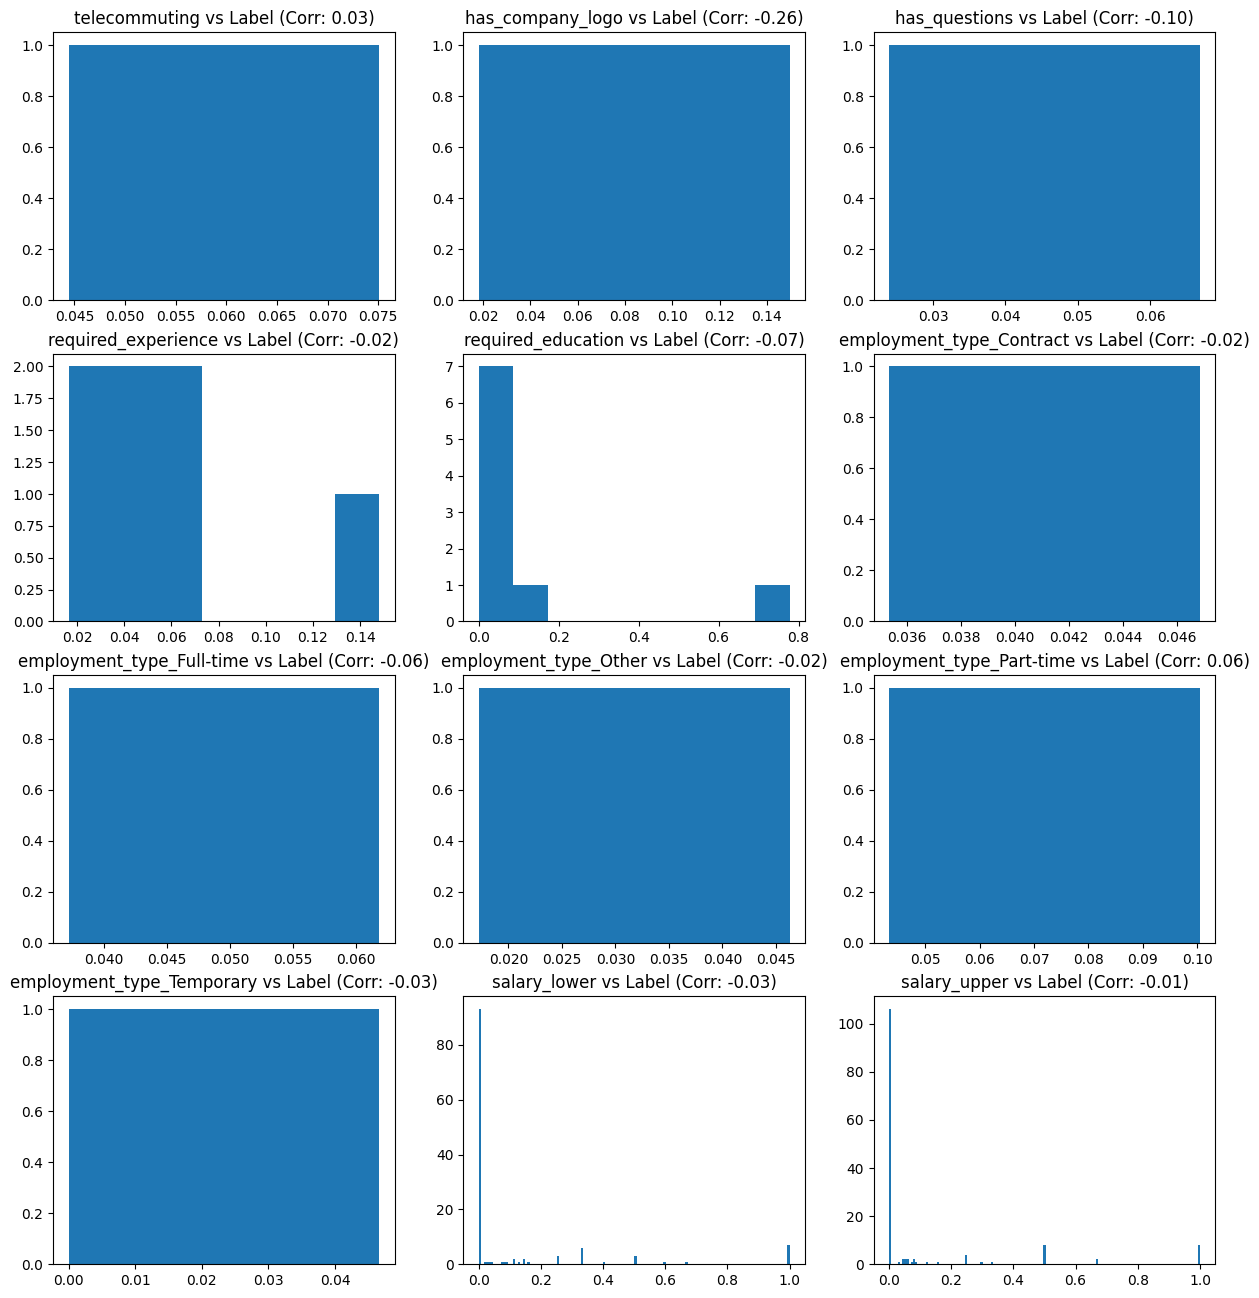

In [37]:
number_columns = ['telecommuting', 'has_company_logo', 'has_questions',
       'required_experience', 'required_education', 'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary', 'salary_lower', 'salary_upper']

# figureを生成
n_features = len(number_columns) - 1  # ラベル列を除いた特徴量の数
n_rows = (n_features + 2) // 3  # 縦に並べるプロットの数（3列で表示）
plt.figure(figsize=(15, 4 * n_rows))  # プロットのサイズを設定

for i, feature in enumerate(number_columns):
    buf = pd.Series(encoded_train_X[feature])

    # 各特徴量とラベル列との相関係数を計算
    correlation = buf.corr(train_y)
    print(f"{feature}とラベルの相関係数: {correlation}")

    # train_yが1の割合を計算
    ratio = buf.groupby(encoded_train_X[feature]).apply(lambda x: np.mean(train_y[x.index]))

    # プロットを生成
    plt.subplot(n_rows, 3, i + 1)
    plt.hist(ratio, bins=len(buf.value_counts()))
    plt.title(f"{feature} vs Label (Corr: {correlation:.2f})")
plt.show()

salaryとexperience, educationにはわずかに関連性がありそうだが、それ以外は特に情報がなさそうだ。

その他の列も観察した。
- title, location, department, industry, function: discriptionで代替可能
- requirements: required_xxxで代用できそう

以上より、情報として価値がありそうなのは'company_profile', 'description', 'benefits', 'required_experience', 'required_education', 'salary_lower', 'salary_upper'だった。

In [39]:
selected_columns = ['company_profile', 'description', 'benefits', 'required_experience', 'required_education', 'salary_lower', 'salary_upper']
reduced_train_X = encoded_train_X[selected_columns]
reduced_test_X = encoded_test_X[selected_columns]
reduced_train_X.head()

,company_profile,description,benefits,required_experience,required_education,salary_lower,salary_upper
0,i28 Technologies has demonstrated expertise in...,Role: Desktop Package/ D...,NaN,NaN,NaN,NaN,NaN
1,Since 1978Our goal has been to create engaging...,THE BACKSTAGE PASS INTERNSHIP IS BACKThe Backs...,"Access: We are a busy agency, but we sincerely...",NaN,NaN,NaN,NaN
2,NaN,General Summary: Achieves maximum sales profit...,Great Health and DentalFast Advancement Opport...,2.0,2.0,55000.0,75000.0
3,Network Closing Services has been serving Lend...,"This is who we are: Network Closing Services, ...",What's in it for you?**SIGN ON BONUS AVAILABLE...,4.0,2.0,NaN,NaN
4,"LEI Home Enhancements, is an Ohio based compan...",Job DescriptionJob DescriptionOur Appointment ...,NaN,2.0,NaN,50.0,65.0


### Embedding
新たな列としてEmbeddingsの要素を保存。

In [48]:
text_columns = ['company_profile', 'description', 'benefits']
vectorized_train_X = copy.deepcopy(reduced_train_X)
vectorized_test_X = copy.deepcopy(reduced_test_X)

for tc in text_columns:
       embeddings_train = model.encode(reduced_train_X[tc].fillna(''))
       embeddings_test = model.encode(reduced_test_X[tc].fillna(''))

       # 行列の各列をDataFrameの新たなカラムとして保存
       for i in range(embeddings_train.shape[1]):
              vectorized_train_X[f'{tc}_{i}'] = embeddings_train[:, i]
              vectorized_test_X[f'{tc}_{i}'] = embeddings_test[:, i]
       vectorized_train_X = vectorized_train_X.drop(tc, axis=1)
       vectorized_test_X = vectorized_test_X.drop(tc, axis=1)

C:\Users\katai\AppData\Local\Temp\ipykernel_10084\3692584907.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vectorized_train_X[f'{tc}_{i}'] = embeddings_train[:, i]
C:\Users\katai\AppData\Local\Temp\ipykernel_10084\3692584907.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vectorized_test_X[f'{tc}_{i}'] = embeddings_test[:, i]
C:\Users\katai\AppData\Local\Temp\ipykernel_10084\3692584907.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [52]:
vectorized_train_X.shape

(4445, 1540)

## モデル構築

カテゴリカルデータ考慮なし

In [53]:
xgb_model = xgb.XGBClassifier(random_state=0) # fix seed

parameters = {
    "n_estimators" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'objective' : ['binary:hinge'] # This makes 0 or 1, rather than producing probabilities.
}
model_opt = GridSearchCV(xgb_model, parameters, scoring="f1")
model_opt.fit(vectorized_train_X, train_y)
print(model_opt.best_params_)

{'max_depth': 2, 'n_estimators': 100, 'objective': 'binary:hinge'}


In [54]:
print(model_opt.best_score_)

0.6389049391908662


カテゴリカルデータ考慮あり（DMatrix）

DMatrixを既存のGridSearchCVでは扱えないので、自分で実装する

In [59]:
def GridSearchCV_with_DMatrix(dtrain, parameters):
    res = {
        "best_score": 0,
        "best_params": None
    }

    # パラメータのすべての組み合わせに対してループ
    for params in product(*parameters.values()):
        param_dict = dict(zip(parameters.keys(), params))

        # 警告回避のためnum_roundだけ除外
        given_param = {
            "max_depth" : param_dict["max_depth"],
            'objective' : 'binary:hinge' # This makes 0 or 1, rather than producing probabilities.
        }
        num_round = param_dict["num_round"]
        
        # モデルの訓練と評価
        trained_model = xgb.train(given_param, dtrain, num_round)
        prediceted_y = trained_model.predict(dtest)
        score = f1_score(test_y, prediceted_y)

        # ベストスコアの更新
        if score > res["best_score"]:
            res["best_score"] = score
            res["best_params"] = param_dict
    
    return res

dtrain = xgb.DMatrix(data=vectorized_train_X, label=train_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能
dtest = xgb.DMatrix(data=vectorized_test_X, label=test_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能

parameters = {
    "num_round" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
}

result = GridSearchCV_with_DMatrix(dtrain, parameters)
print(result)

{'best_score': 1.0, 'best_params': {'num_round': 20, 'max_depth': 8}}


## 本番テスト
問題文データを解く

### データ準備
学習モデルに入力できるフォーマットに変換

In [60]:
selected_columns_default = ['company_profile', 'description', 'benefits', 'required_experience', 'required_education', 'salary_range']

encoded_quiz = copy.deepcopy(quiz[selected_columns_default])
encoded_quiz['required_experience'] = encoded_quiz['required_experience'].apply(encoder_experience)
encoded_quiz['required_education'] = encoded_quiz['required_education'].apply(encoder_education)
encoded_quiz = split_columns_salary(encoded_quiz)
encoded_quiz.head()

,company_profile,description,benefits,required_experience,required_education,salary_lower,salary_upper
0,"We're Food52, and we've created a groundbreaki...","Food52, the James Beard Award-winning online f...",NaN,NaN,NaN,NaN,NaN
1,"We design, deploy, and maintain advanced techn...",We are looking for a highly motivated and qual...,"At Fivesky, our employees are our greatest ass...",NaN,5.0,NaN,NaN
2,NaN,Qualified candidates will be responsible for b...,NaN,2.0,2.0,48000.0,58000.0
3,SpotSource Solutions LLC is a Global Human Cap...,Title: Sales Support Type: Permanent – Full-T...,Benefits Offered,2.0,0.0,30000.0,40000.0
4,Established on the principles that full time e...,Government funding is only available for 16-18...,Career prospects.,0.0,2.0,NaN,NaN


In [62]:
text_columns = ['company_profile', 'description', 'benefits']

for tc in text_columns:
       embeddings_train = model.encode(encoded_quiz[tc].fillna(''))

       # 行列の各列をDataFrameの新たなカラムとして保存
       columns = []
       for i in range(embeddings_train.shape[1]):
              columns.append(f'{tc}_{i}')
       emb_df = pd.DataFrame(embeddings_train, columns=columns)
       encoded_quiz = pd.concat([encoded_quiz, emb_df], axis=1)

       encoded_quiz = encoded_quiz.drop(tc, axis=1)

print(encoded_quiz.shape)

(100, 1540)


### モデル構築、評価
先ほど調べた最適パラメータを使ってモデルをつくる

In [63]:
train_X_set = pd.concat([vectorized_train_X, vectorized_test_X], axis=0)
train_y_set = pd.concat([train_y, test_y], axis=0)

dtrain = xgb.DMatrix(data=train_X_set, label=train_y_set, enable_categorical=True) # カテゴリカルデータの分類は実験的機能

num_round = 20
given_param = {
    'max_depth': 8,
    'objective' : 'binary:hinge'
}
trained_model = xgb.train(given_param, dtrain, num_round)

正答率を評価

In [66]:
dtest = xgb.DMatrix(data=encoded_quiz, enable_categorical=True)

prediceted_y = trained_model.predict(dtest)
accuracy_score(quiz_solution, prediceted_y)

0.81

8割の正答率達成！